## Импорты и настройка окружения

In [1]:
import os
import time
import re
from enum import Enum

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mlflow
from mlflow.models.signature import infer_signature

from sklearn.metrics import accuracy_score, confusion_matrix

import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets, models, transforms

from tqdm import tqdm, trange
from pyngrok import ngrok

In [2]:
%env MLFLOW_TRACKING_URI=sqlite:///mlruns.db

env: MLFLOW_TRACKING_URI=sqlite:///mlruns.db


## Трансформация

In [3]:
distortion_scale = 0.3

In [4]:
transform = transforms.Compose([
    #transforms. ElasticTransform(alpha=60.0 ),
    transforms.RandomRotation(degrees=30.0),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.5, 1)),
    transforms.RandomPerspective(p=0.9, distortion_scale=distortion_scale),
    #transforms.RandomResizedCrop(size=(28, 28),scale=(0.7, 0.8), ratio=(0.7, 0.8)),
    transforms.ToTensor()
])

In [5]:
def get_transform():
    try:
        transform
    except NameError:
        return transforms.Compose([transforms.ToTensor()])
    else:
        return transform

In [6]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt_ax.imshow(inp)
    
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

## Погрузка и настройка данных

In [7]:
generator1 = torch.Generator().manual_seed(42)

dataset_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataset_train_augm = datasets.MNIST(root='./data', train=True, download=True,transform=transform)
dataset = torch.utils.data.ConcatDataset(
    [dataset_train, dataset_train_augm]
)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=generator1)

DEVICE = torch.device("cpu")

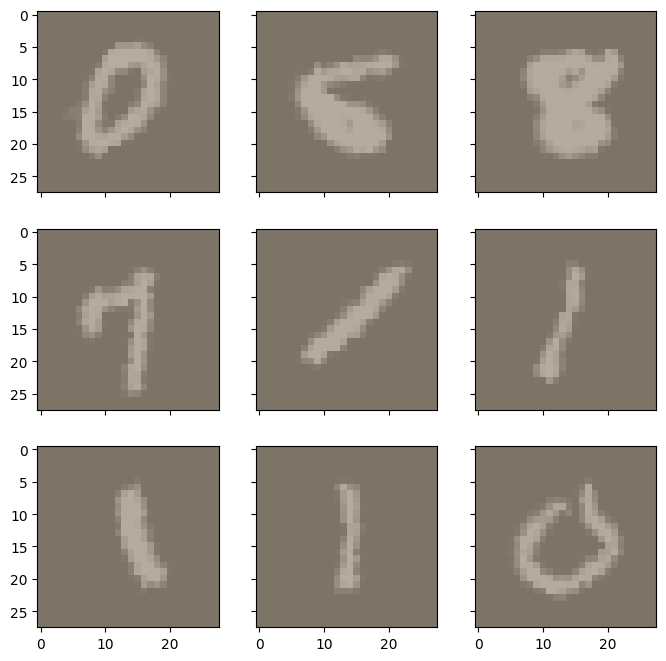

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = dataset_train_augm[random_characters]
    
    imshow(im_val.data.cpu(), plt_ax=fig_x)

## Методы обучения, предсказания и оценки

In [8]:
class Timer:
    def __enter__(self):
        self._start = time.time()
        return self

    def __exit__(self, type, value, traceback):
        self._end = time.time()

    def __str__(self):
        num = self.float_round()
        return f'{num} seconds'
    
    def float_round(self, cnt_numbers: int = 4) -> float:
        return round(self._end - self._start, cnt_numbers)

In [9]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data_count = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data_count += inputs.size(0)

    train_loss = running_loss / processed_data_count
    train_acc = running_corrects.cpu().numpy() / processed_data_count

    return train_loss, train_acc

In [10]:
def eval_epoch(model, val_loader, criterion):
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)

            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size

    return val_loss, val_acc

In [11]:
def train(train_files, val_files, model, epochs: int, batch_size: int, num_samples: int):
    train_sampler=torch.utils.data.RandomSampler(train_dataset, num_samples=num_samples)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler) # shuffle=True,
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [12]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            if isinstance(inputs, tuple) or isinstance(inputs, list) and len(inputs) == 2:
                # if the loader is really loader, then it returns tuple(X, y)
                inputs = inputs[0]

            inputs = inputs.to(DEVICE)
            model.eval()
            
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## Архитектуры

### Архитектура EnsNet

In [14]:
class EnsNet(nn.Module):
  def __init__(self, num_classes=10):
      super(EnsNet, self).__init__()
      self.features = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Dropout(0.35),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.35),
        nn.Conv2d(128, 256, 3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.35),
        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.35),
        nn.Conv2d(512, 1024, kernel_size=3),
        nn.BatchNorm2d(1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.35),
        
      )
      self.avgpool = nn.AdaptiveAvgPool2d((3, 3))
      self.classifier_major = nn.Linear(216, num_classes)
      self.classifiers = nn.ModuleList([
          nn.Linear(216, num_classes)
          for _ in range(10)
      ])
      self.weights = nn.Parameter(torch.ones(11) / 11, requires_grad=True)

  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x_major = self.classifier_major(x[:, :216])
    x_rest = [classifier(x[:, 216 * i :216 * (i + 1) ]) for i, classifier in enumerate(self.classifiers)]
    all_x = torch.stack([x_major] + x_rest, dim=1)
    weighted_x = torch.sum(all_x * self.weights.view(1, -1, 1), dim=1)
    return weighted_x

### AlexNet

In [40]:
class AlexNet(nn.Module):   
    def __init__(self, num=10):
        super(AlexNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True), 
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),   
            nn.MaxPool2d( kernel_size=2, stride=2),
            nn.Conv2d(64, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),                         
            nn.Conv2d(96, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),                         
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=2, stride=1),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(32*12*12,2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,num),
         
        )
    
    def forward(self, x):

        x = self.feature(x)
        x = x.view(-1,32*12*12)
        x = self.classifier(x)
        return x

### VGG8

In [39]:
class VGG8(nn.Module):
    def __init__(self):
        super(VGG8, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=6,  kernel_size=(3,3)),  nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))

        self.conv2 = nn.Sequential(nn.Conv2d(6, 16, kernel_size=(3,3)), nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))

        self.conv3 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=(3,3)), nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))

        self.conv4 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=(3,3)), nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))
        self.conv5 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=(3,3)), nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))
        self.fc1 = nn.Sequential(nn.Flatten(),nn.Linear(5184, 64), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(64, 128), nn.ReLU())
        self.fc3 = nn.Linear(128,10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

### ResNet

In [40]:
class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(out_channels)
      )
  def forward(self, x):
    out = nn.ReLU(inplace=True)(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = nn.ReLU(inplace=True)(out)
    return out

class ResNet(nn.Module):
  def __init__(self, num_classes=10):
    super(ResNet, self).__init__()
    self.in_channels = 16

    self.model = nn.Sequential(
      nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False),
      nn.BatchNorm2d(16),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
      self._make_layer(16, 2, stride=1),
      self._make_layer(32, 2, stride=2),
      self._make_layer(64, 2, stride=2),
      self._make_layer(128, 2, stride=2),
      nn.AdaptiveAvgPool2d((1, 1)),
      nn.Flatten(start_dim=1),
      nn.Linear(128, num_classes)
  )
    self._initialize_weights()

  def _make_layer(self, out_channels, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(BasicBlock(self.in_channels, out_channels, stride))
      self.in_channels = out_channels
    return nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(m.bias, 0)

### LeNet

In [13]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5), nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))
        self.conv2 = nn.Sequential(nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),nn.MaxPool2d(stride=1, kernel_size=(2*2)))
        self.fc1 = nn.Sequential(nn.Flatten(),nn.Linear(3136, 120), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(120, 84), nn.ReLU())
        self.fc3 = nn.Linear(84,10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

### Подгрузка модели

In [14]:
class NNNetEnum(Enum):
    ens_net = 1
    alex_net = 2
    vgg8 = 3
    res_net = 4
    le_net = 5

In [15]:
def get_nn_model(nn_model: NNNetEnum):
    model_class = None
    if nn_model == NNNetEnum.ens_net:
        model_class =  EnsNet
    if nn_model == NNNetEnum.alex_net:
        model_class =  AlexNet
    if nn_model == NNNetEnum.vgg8:
        model_class =  VGG8
    if nn_model == NNNetEnum.res_net:
        model_class =  ResNet
    if nn_model == NNNetEnum.le_net:
        model_class =  LeNet

    if model_class is None:
        raise Exception(f'The passed architecture {nn_model} was not found. Check enum conditions.')
    
    return model_class().to(DEVICE)

## Тесты архитектур

In [16]:
simple_cnn = get_nn_model(NNNetEnum.le_net)

In [17]:
epoch = 1
batch_size = 64
num_samples = 5000

In [18]:
with Timer() as train_timer:
    history = train(train_dataset, val_dataset, model=simple_cnn, epochs=epoch, batch_size=batch_size, num_samples=num_samples)

epoch:   0%|                                                                                     | 0/1 [00:00<?, ?it/s]

loss 1.5128696024417878


epoch: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.31s/it]


Epoch 001 train_loss: 1.5129     val_loss 0.9036 train_acc 0.4962 val_acc 0.6763


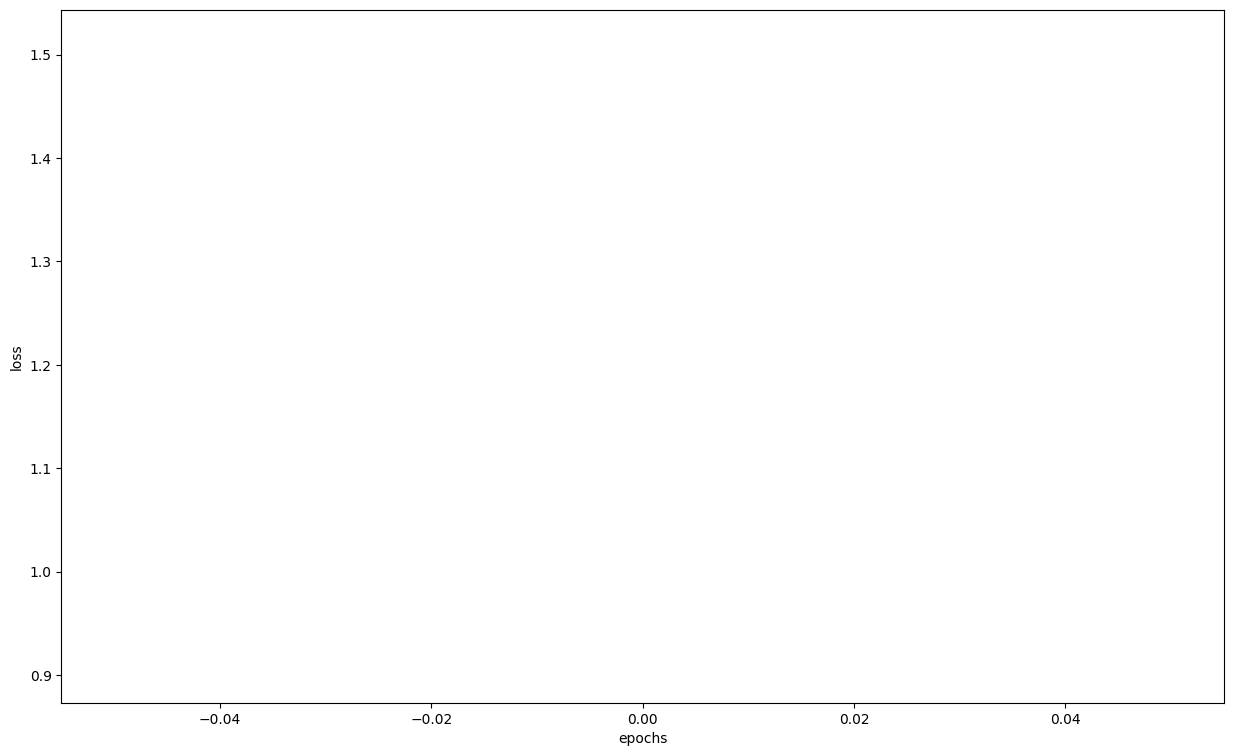

In [19]:
train_loss, train_acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [21]:
test_img = [test_dataset[i][0].unsqueeze(0) for i in range(len(test_dataset))]

with Timer() as test_timer:
    test_pred = predict(simple_cnn, test_img)
    y_pred = np.argmax(test_pred,-1)


#### Accuracy по классам

In [22]:
proba_ = predict(simple_cnn, DataLoader(test_dataset, batch_size=1, shuffle=False))
predict_ = np.argmax(proba_, -1)
actual_labels = [el[1] for el in test_dataset]

matrix = confusion_matrix(actual_labels, predict_)
ac_class = matrix.diagonal() / matrix.sum(axis=1)
print('ACCURACY', list(ac_class))

ACCURACY [0.9979591836734694, 0.9832599118942731, 0.8304263565891473, 0.7514851485148515, 0.9307535641547862, 0.8217488789237668, 0.7578288100208769, 0.9134241245136187, 0.7741273100616016, 0.6005946481665014]


#### Общий accuracy

In [128]:
actual_labels =[test_dataset[i][1] for i in range(len(test_dataset))]

ac = accuracy_score(actual_labels, y_pred)

print("ACCURACY general:", ac, 'ACCURACY by classes:', sum(ac_class) / 10)

ACCURACY general: 0.9824 ACCURACY by classes: 0.98239584441748


In [129]:
simple_cnn.__class__.__name__

'LeNet'

In [130]:
params = {"epoch": epoch, "batch_size": batch_size}

for transform_el in get_transform().transforms:
    val = re.sub(r'\w+\(', '', str(transform_el))[:-1]
    
    if not val:
        continue
    
    if transform_el.__class__.__name__=='RandomPerspective':
        val=f'{val}, distortion_scale={distortion_scale}'
    print(val)
    params[transform_el.__class__.__name__] = val

print(params)

degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0
p=0.9, distortion_scale=0.3
{'epoch': 35, 'batch_size': 64, 'RandomRotation': 'degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0', 'RandomPerspective': 'p=0.9, distortion_scale=0.3'}


## Логирование в MLFlow

In [131]:
model_name = simple_cnn.__class__.__name__

params = {"epoch": epoch, "batch_size": batch_size, "num_samples": num_samples}

for transform_el in get_transform().transforms:
    val = re.sub(r'\w+\(', '', str(transform_el))[:-1]
    
    if not val:
        continue

    if transform_el.__class__.__name__=='RandomPerspective':
        val=f'{val}, distortion_scale={distortion_scale}'
    print(val)
    
    print(val)
    params[transform_el.__class__.__name__] = val


mlflow.set_tracking_uri(uri="sqlite:///mlruns.db")
mlflow.set_experiment(model_name)


with mlflow.start_run(run_name=model_name):
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the metric
    mlflow.log_metric("accuracy", ac)
    mlflow.log_metric("train_time_seconds", train_timer.float_round())
    mlflow.log_metric("pred_time_seconds", test_timer.float_round())

    for i in range(10):
         mlflow.log_metric(f"accuracy_{i}", round(ac_class[i], 5))

    # Log the model
    model_info = mlflow.pytorch.log_model(
        pytorch_model=simple_cnn,
        artifact_path=model_name,
        #signature = infer_signature(train_set_array, train_pred),
        #input_example=train_set_array,
        registered_model_name=model_name,
    )

degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0
degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0
p=0.9, distortion_scale=0.3
p=0.9, distortion_scale=0.3


Registered model 'LeNet' already exists. Creating a new version of this model...
Created version '91' of model 'LeNet'.
